In [1]:
import subprocess
import os
import sys
import numpy as np
import pandas as pd
import random
import csv
import time
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn-poster")

In [12]:
class midiFile(object):
    def __init__(self,fname):
        self.fname = fname
        self.oname = os.path.splitext(self.fname)[0] + "_NNCompose.mid"
        self.my_cols = ["instrument", "timing", "cmd","pitchshift","note","velocity","timeSig"]
        self.convertMidToCsv()
        self.df = self.convertCsvToDataframe()
        self.header = self.df[self.df['cmd'].str.contains("Header")]
        self.qn = int(self.header.iloc[0]['velocity'])
        self.tempo = int(self.df[self.df['cmd'].str.contains("Tempo")].iloc[0]['pitchshift'])
        self.command = self.df[self.df['instrument'] == 1]
        self.track2 = self.df[self.df['instrument'] == 2]
        self.startTrack = self.track2[self.track2['cmd'].str.contains("Start")]
        self.eof = self.df[self.df['cmd'].str.contains("End_of_file")]
        self.df = self.df[self.df['cmd'].str.contains("Note_on")]
        self.df['note'] = self.df['note'].apply(np.int64)

    def forceDataTypes(self,df):
        df['instrument'] = df['instrument'].astype(int)
        df['timing'] = df['timing'].astype(int)
        df['pitchshift'] = df['pitchshift'].astype(int)
        df['note'] = df['note'].astype(int)
        df['velocity'] = df['velocity'].astype(int)
        df['cmd'] = df['cmd'].astype(str)

    def convertMidToCsv(self):
        basename = os.path.splitext(self.fname)
        inp = "midiIn/" + str(basename[0]) + ".mid"
        if not os.path.isfile(inp):
            print("Did not find .mid file, trying .midi!")
            inp = "midiIn/" + str(basename[0]) + ".midi"
            if not os.path.isfile(inp):
                raise ValueError("No MIDI File Found")
        out = "csv/" + str(basename[0]) + ".csv"
        cmd = "midicsv " + inp + " >! " + out 
        csvCreated = subprocess.Popen(cmd, shell=True)
        print("Converting to CSV")
        time.sleep(5)

    def convertCsvToDataframe(self):
        basename = os.path.splitext(self.fname)
        inp = "csv/" + str(basename[0]) + ".csv"
        return pd.read_csv(inp, names=self.my_cols)

    def convertNotesToName(self):
        notename = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        #self.df['noteName'] = self.df['note'].apply(lambda x: int(x % 12))
        self.df['noteName'] = self.df['note'] #if trying to include octaves)

    def convertMidiToMp3(self):
        basename = os.path.splitext(self.oname)
        inname = "midiOut/" + str(basename[0]) + ".mid"
        outname = "mp3Out/" + str(basename[0]) + ".mp3"
        cmd = "timidity -Ow -o - " + inname + "| lame - " + outname
        mp3Created = subprocess.Popen(cmd, shell=True)
        time.sleep(5)
        print("Created ", outname)
        
    def get_trainable_arrays(self, seq_length=10):
        data = self.df['note'].values
        x = []
        y = []
        for i in range(seq_length,len(data)):
            x.append(data[i-seq_length:i])
            y.append(data[i])
        print("X & Y Correlation:\n",x[0],y[0],"\nActual Data Correlation:\n",data[seq_length-2:seq_length+1])
        X = np.reshape(x, (len(x), seq_length, 1))
        Y = np.reshape(y, len(y))
        return X,Y
        
    def encode_target(self, y):
        n_values = 128
        ohe = np.eye(n_values)[y]
        return ohe
    
    def convert_to_midi_format(self, result_notes):
        notes = []
        currentTime = 0

        for ind in result_notes:
            beatLength = 3
            while beatLength in [3,5,6,7]:
                beatLength = random.randint(1,4)
            dt = int(self.qn/beatLength)
            endtime = currentTime + dt
            
            for note in ind:
                notes.append([2,currentTime, "Note_on_c", 2, int(note), 95,False])
                notes.append([2,endtime, "Note_off_c", 2, int(note), 95, False])
            currentTime = endtime
        notes.append([2, currentTime, "End_track"])
        return sorted(notes,key=itemgetter(1))
    
    def check_valid_entry(self, item):
        if type(item) == str:
            return True
        elif not np.isnan(item):
            return True
        else:
            return False    

    def makeMidiOut(self,notes):
        basename = os.path.splitext(self.oname)
        filename = "csv/"+str(basename[0])+".csv"
        file_order = [self.header,self.command,self.startTrack,notes]
        with open(filename, 'w') as f:
            for section in file_order:
                if not type(section) == list:
                    try:
                        l = section.values.tolist()
                    except AttributeError:
                        l = section.tolist()
                else:
                    l = section
                for item in l:
                    outstr = ""
                    
                    if len(item) == 3:
                        if self.check_valid_entry(item[0]):
                            outstr = outstr + str(int(item[0])) + ", "
                        if self.check_valid_entry(item[1]):
                            outstr = outstr + str(int(item[1])) + ", " 
                        if self.check_valid_entry(item[2]):
                            outstr = outstr + str(item[2].lstrip(' ')) + ", "
                    else:
                        if self.check_valid_entry(item[0]):
                            outstr = outstr + str(int(item[0])) + ", "
                        if self.check_valid_entry(item[1]):
                            outstr = outstr + str(int(item[1])) + ", " 
                        if self.check_valid_entry(item[2]):
                            outstr = outstr + str(item[2].lstrip(' ')) + ", "
                        if self.check_valid_entry(item[3]):
                            if type(item[3]) == str:
                                outstr = outstr + str(item[3]) + ", "
                            else:
                                outstr = outstr + str(int(item[3])) + ", "
                        if self.check_valid_entry(item[4]):
                            outstr = outstr + str(int(item[4])) + ", "
                        if self.check_valid_entry(item[5]):
                            outstr = outstr + str(int(item[5])) + ", "
                        if self.check_valid_entry(item[6]):
                            outstr = outstr + str(int(item[6])) + ", "
                    outstr = outstr.rstrip(', ') + "\n"
                    f.write(outstr)
            item = self.eof.iloc[0].values
            if self.check_valid_entry(item[0]):
                outstr = outstr + str(int(item[0])) + ", "
            if self.check_valid_entry(item[1]):
                outstr = outstr + str(int(item[1])) + ", " 
            if self.check_valid_entry(item[2]):
                outstr = outstr + str(item[2].lstrip(' ')) + ", "
            outstr = outstr.rstrip(', ') + "\n"
            f.write(outstr)
        self.csv_to_midi()
    
    def csv_to_midi(self):
        basename = os.path.splitext(self.oname)
        filename = "csv/"+str(basename[0])+".csv"
        out = "midiOut/" + str(basename[0]) + ".mid"
        cmd = "csvmidi " + filename + " " + out 
        midCreated = subprocess.Popen(cmd, shell=True)
        print("Converting to MIDI")
        time.sleep(5)

In [3]:
# Create first network with Keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
#sciKit for pipeline and CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class network(object):
    def __init__(self, X):
        self.model = self.getModel(X)

    def getModel(self,X):
        # create model
        model = Sequential()
        model.add(LSTM(400, input_shape=(X.shape[1],X.shape[2]), return_sequences=True))
        model.add(LSTM(200, input_shape=(X.shape[1],X.shape[2])))
        model.add(Dense(128,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model
    
    def train(self,x,y,epochs=20,batch_size=5,filepath="recent_lstm_model_weights.h5"):
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        # fit the model
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
        self.model = self.load_best_model(filepath)
        return self.model
        
    def load_best_model(self, filepath="recent_lstm_model_weights.h5"):
        return load_model(filepath)

Using TensorFlow backend.


In [4]:
import os
fileNames = [fileName for fileName in os.listdir("midiIn") if 'Bach' in str(fileName)]
fileNames

['Bach_Cantate_BWV33.mid',
 'Bach_My_Heart_Ever_Faithful_BWV34.mid',
 'Bach_Cantate_BWV8.midi',
 'Bach_Christ_Lay_Bonds_Death_BWV4.mid',
 'Bach_How_Brightly_Shines_Morning_Star_BWV1.mid',
 'Bach_Cantate_BWV20.mid']

In [ ]:
####### For Training across all songs in the fileNames list
#######

# sl = 20
# X = np.empty(shape=(10, sl, 1)) # shape[0] doesn't matter to the model
# model = network(X)
# data_seeds = []
# for track in fileNames:
#     mf = midiFile(track)
#     X,Y = mf.get_trainable_arrays(seq_length=sl)
#     data_seed = X[0]
#     data_seed = np.reshape(data_seed, (1, sl, 1))
#     data_seeds.append(data_seed)
#     target = mf.encode_target(Y)
#     model.train(X,target,epochs=100,batch_size=5)

Converting to CSV
X & Y Correlation:
 [50 57 65 60 57 53 52 62 58 50 64 65 48 67 69 60 53 52 60 67] 65 
Actual Data Correlation:
 [60 67 65]
Epoch 1/100
249/249 [==============================] - 10s - loss: 3.6394    
Epoch 2/100
249/249 [==============================] - 8s - loss: 3.0861     
Epoch 3/100
249/249 [==============================] - 8s - loss: 3.0685     
Epoch 4/100
249/249 [==============================] - 8s - loss: 3.0627     
Epoch 5/100
249/249 [==============================] - 8s - loss: 3.0555     
Epoch 6/100
249/249 [==============================] - 8s - loss: 3.0435     
Epoch 7/100
249/249 [==============================] - 8s - loss: 3.0428     
Epoch 8/100
249/249 [==============================] - 8s - loss: 3.0353     
Epoch 9/100
249/249 [==============================] - 8s - loss: 3.0172     
Epoch 10/100
249/249 [==============================] - 8s - loss: 3.0310     
Epoch 11/100
249/249 [==============================] - 8s - loss: 3.0148     

249/249 [==============================] - 8s - loss: 2.6026     
Epoch 38/100
249/249 [==============================] - 8s - loss: 2.5726     
Epoch 39/100
249/249 [==============================] - 8s - loss: 2.5644     
Epoch 40/100
249/249 [==============================] - 8s - loss: 2.5312     
Epoch 41/100
249/249 [==============================] - 8s - loss: 2.5184     
Epoch 42/100
249/249 [==============================] - 8s - loss: 2.4785     
Epoch 43/100
249/249 [==============================] - 8s - loss: 2.4525     
Epoch 44/100
249/249 [==============================] - 8s - loss: 2.4130     
Epoch 45/100
249/249 [==============================] - 8s - loss: 2.4098     
Epoch 46/100
249/249 [==============================] - 8s - loss: 2.4074     
Epoch 47/100
249/249 [==============================] - 8s - loss: 2.3835     
Epoch 48/100
249/249 [==============================] - 8s - loss: 2.3292     
Epoch 49/100
249/249 [==============================] - 8s - loss

249/249 [==============================] - 8s - loss: 1.6834     
Epoch 73/100
249/249 [==============================] - 8s - loss: 1.6279     
Epoch 74/100
249/249 [==============================] - 8s - loss: 1.5798     
Epoch 75/100
249/249 [==============================] - 8s - loss: 1.5869     
Epoch 76/100
249/249 [==============================] - 8s - loss: 1.5643     
Epoch 77/100
249/249 [==============================] - 8s - loss: 1.4817     
Epoch 78/100
249/249 [==============================] - 8s - loss: 1.4778     
Epoch 79/100
249/249 [==============================] - 8s - loss: 1.4140     
Epoch 80/100
249/249 [==============================] - 8s - loss: 1.4116     
Epoch 81/100
249/249 [==============================] - 8s - loss: 1.3803     
Epoch 82/100
249/249 [==============================] - 8s - loss: 1.3428     
Epoch 83/100
249/249 [==============================] - 8s - loss: 1.3217     
Epoch 84/100
249/249 [==============================] - 8s - loss

168/168 [==============================] - 5s - loss: 3.8122     
Epoch 17/100
168/168 [==============================] - 5s - loss: 3.8381     
Epoch 18/100
168/168 [==============================] - 5s - loss: 3.7717     
Epoch 19/100
168/168 [==============================] - 5s - loss: 3.7467     
Epoch 20/100
168/168 [==============================] - 5s - loss: 3.6773     
Epoch 21/100
168/168 [==============================] - 5s - loss: 3.6630     
Epoch 22/100
168/168 [==============================] - 5s - loss: 3.6991     
Epoch 23/100
168/168 [==============================] - 5s - loss: 3.6517     
Epoch 24/100
168/168 [==============================] - 5s - loss: 3.5960     
Epoch 25/100
168/168 [==============================] - 5s - loss: 3.5898     
Epoch 26/100
168/168 [==============================] - 5s - loss: 3.5668     
Epoch 27/100
168/168 [==============================] - 5s - loss: 3.5671     
Epoch 28/100
168/168 [==============================] - 5s - loss

168/168 [==============================] - 5s - loss: 3.0671     
Epoch 54/100
168/168 [==============================] - 5s - loss: 3.0674     
Epoch 55/100
168/168 [==============================] - 5s - loss: 3.0479     
Epoch 56/100
168/168 [==============================] - 5s - loss: 3.0265     
Epoch 57/100
168/168 [==============================] - 5s - loss: 3.0202     
Epoch 58/100
168/168 [==============================] - 5s - loss: 2.9709     
Epoch 59/100
168/168 [==============================] - 5s - loss: 2.9668     
Epoch 60/100
168/168 [==============================] - 5s - loss: 2.9539     
Epoch 61/100
168/168 [==============================] - 5s - loss: 2.9207     
Epoch 62/100
168/168 [==============================] - 5s - loss: 2.8915     
Epoch 63/100
168/168 [==============================] - 5s - loss: 2.8806     
Epoch 64/100
168/168 [==============================] - 5s - loss: 2.9025     
Epoch 65/100
168/168 [==============================] - 5s - loss

190/190 [==============================] - 6s - loss: 2.9522     
Epoch 26/100
190/190 [==============================] - 6s - loss: 2.8513     
Epoch 27/100
190/190 [==============================] - 6s - loss: 2.9048     
Epoch 28/100
190/190 [==============================] - 6s - loss: 2.8105     
Epoch 29/100
190/190 [==============================] - 6s - loss: 2.7932     
Epoch 30/100
190/190 [==============================] - 6s - loss: 2.7413     
Epoch 31/100
190/190 [==============================] - 6s - loss: 2.7056     
Epoch 32/100
190/190 [==============================] - 6s - loss: 2.7437     
Epoch 33/100
190/190 [==============================] - 6s - loss: 2.6987     
Epoch 34/100
190/190 [==============================] - 6s - loss: 2.6536     
Epoch 35/100
190/190 [==============================] - 6s - loss: 2.6394     
Epoch 36/100
190/190 [==============================] - 6s - loss: 2.6130     
Epoch 37/100
190/190 [==============================] - 6s - loss

190/190 [==============================] - 6s - loss: 2.1353     
Epoch 63/100
190/190 [==============================] - 6s - loss: 2.1087     
Epoch 64/100
190/190 [==============================] - 6s - loss: 2.1150     
Epoch 65/100
190/190 [==============================] - 6s - loss: 2.0967     
Epoch 66/100
190/190 [==============================] - 6s - loss: 2.1002     
Epoch 67/100
190/190 [==============================] - 6s - loss: 2.0859     
Epoch 68/100
190/190 [==============================] - 6s - loss: 2.0508     
Epoch 69/100
190/190 [==============================] - 6s - loss: 2.0384     
Epoch 70/100
190/190 [==============================] - 6s - loss: 2.0655     
Epoch 71/100
190/190 [==============================] - 6s - loss: 2.0182     
Epoch 72/100
190/190 [==============================] - 6s - loss: 2.0144     
Epoch 73/100
190/190 [==============================] - 6s - loss: 1.9980     
Epoch 74/100
190/190 [==============================] - 6s - loss

212/212 [==============================] - 7s - loss: 3.3037     
Epoch 35/100
212/212 [==============================] - 7s - loss: 3.2701     
Epoch 36/100
212/212 [==============================] - 7s - loss: 3.2246     
Epoch 37/100
212/212 [==============================] - 7s - loss: 3.2012     
Epoch 38/100
212/212 [==============================] - 7s - loss: 3.1653     
Epoch 39/100
212/212 [==============================] - 7s - loss: 3.1661     
Epoch 40/100
212/212 [==============================] - 7s - loss: 3.1410     
Epoch 41/100
212/212 [==============================] - 7s - loss: 3.1089     
Epoch 42/100
212/212 [==============================] - 7s - loss: 3.0907     
Epoch 43/100
212/212 [==============================] - 7s - loss: 3.0710     
Epoch 44/100
212/212 [==============================] - 7s - loss: 3.0927     
Epoch 45/100
212/212 [==============================] - 7s - loss: 3.0554     
Epoch 46/100
212/212 [==============================] - 7s - loss

129/129 [==============================] - 4s - loss: 3.8785     
Epoch 8/100
129/129 [==============================] - 4s - loss: 3.8304     
Epoch 9/100
129/129 [==============================] - 4s - loss: 3.7580     
Epoch 10/100
129/129 [==============================] - 4s - loss: 3.7332     
Epoch 11/100
129/129 [==============================] - 4s - loss: 3.7366     
Epoch 12/100
129/129 [==============================] - 4s - loss: 3.7065     
Epoch 13/100
129/129 [==============================] - 4s - loss: 3.6323     
Epoch 14/100
129/129 [==============================] - 4s - loss: 3.6177     
Epoch 15/100
129/129 [==============================] - 4s - loss: 3.6309     
Epoch 16/100
129/129 [==============================] - 4s - loss: 3.7052     
Epoch 17/100
129/129 [==============================] - 4s - loss: 3.6186     
Epoch 18/100
129/129 [==============================] - 4s - loss: 3.6284     
Epoch 19/100
129/129 [==============================] - 4s - loss: 

129/129 [==============================] - 4s - loss: 2.5306     
Epoch 84/100
129/129 [==============================] - 4s - loss: 2.5277     
Epoch 85/100
129/129 [==============================] - 4s - loss: 2.5551     
Epoch 86/100
129/129 [==============================] - 4s - loss: 2.5379     
Epoch 87/100
129/129 [==============================] - 4s - loss: 2.5299     
Epoch 88/100
129/129 [==============================] - 4s - loss: 2.5058     
Epoch 89/100
129/129 [==============================] - 4s - loss: 2.4914     
Epoch 90/100
129/129 [==============================] - 4s - loss: 2.4444     
Epoch 91/100
129/129 [==============================] - 4s - loss: 2.4371     
Epoch 92/100
129/129 [==============================] - 4s - loss: 2.3916     
Epoch 93/100
129/129 [==============================] - 4s - loss: 2.3950     
Epoch 94/100
129/129 [==============================] - 4s - loss: 2.3954     
Epoch 95/100
129/129 [==============================] - 4s - loss

### Load model and track, setup data

In [13]:
sl = 20
X = np.empty(shape=(10, sl, 1)) # shape[0] doesn't matter to the model
model = network(X).load_best_model()

mf = midiFile(fileNames[-1])
X,Y = mf.get_trainable_arrays(seq_length=sl)
data_seed = X[0]
data_seed = np.reshape(data_seed, (1, sl, 1))
target = mf.encode_target(Y)

Converting to CSV
X & Y Correlation:
 [62 47 50 59 55 50 57 50 55 62 55 47 62 45 43 64 55 48 64 49] 57 
Actual Data Correlation:
 [64 49 57]


In [6]:
pl_results = []
results = []
for i in range(2000):
    if i%500==0:
        print("Generating point ",i)
    data_seed = np.reshape(data_seed, (1, sl, 1))
    next_val = model.model.predict(data_seed)
    results.append([list(np.where(next_val[0]==x)[0])[0] for x in next_val[0] if x > 0.2])
    next_val = np.argmax(next_val)
    pl_results.append(next_val)
    next_val = np.reshape(next_val,(1))
    data_seed = data_seed[0].tolist()
    data_seed.append([next_val])
    data_seed = data_seed[1:len(data_seed)]

Generating point  0
Generating point  500
Generating point  1000
Generating point  1500


In [10]:
train_results = model.model.predict(X)
tr_results = []
for val in train_results:
    tr_results.append(np.argmax(val))

In [36]:
preds = model.model.predict(X)
tr_results = []
plot_results = []
for p in preds:
    tr_results.append([list(np.where(p==x)[0])[0] for x in p if x > 0.2])
    plot_results.append(np.argmax(p))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


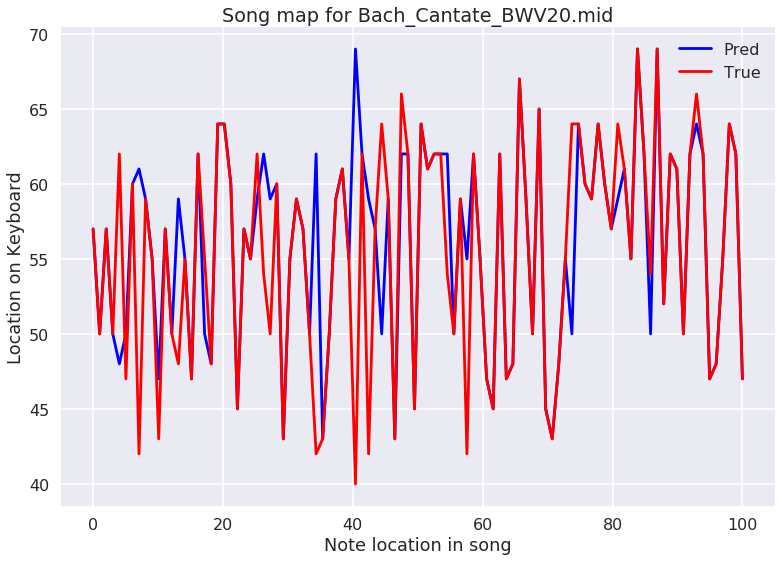

In [13]:
lowx = 0
highx = 100
plt.plot(np.linspace(0,len(plot_results[lowx:highx]),len(plot_results[lowx:highx])),plot_results[lowx:highx],'b',label="Pred")
plt.plot(np.linspace(0,len(Y[lowx:highx]),len(Y[lowx:highx])),Y[lowx:highx],'r',label="True");
plt.xlabel("Note location in song")
plt.ylabel("Location on Keyboard")
plt.title("Song map for %s"%mf.fname)
plt.legend()

In [37]:
notes = mf.convert_to_midi_format(tr_results)
mf.makeMidiOut(notes)

Converting to MIDI


In [38]:
mf.convertMidiToMp3()

Created  mp3Out/Bach_Cantate_BWV20_NNCompose.mp3


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


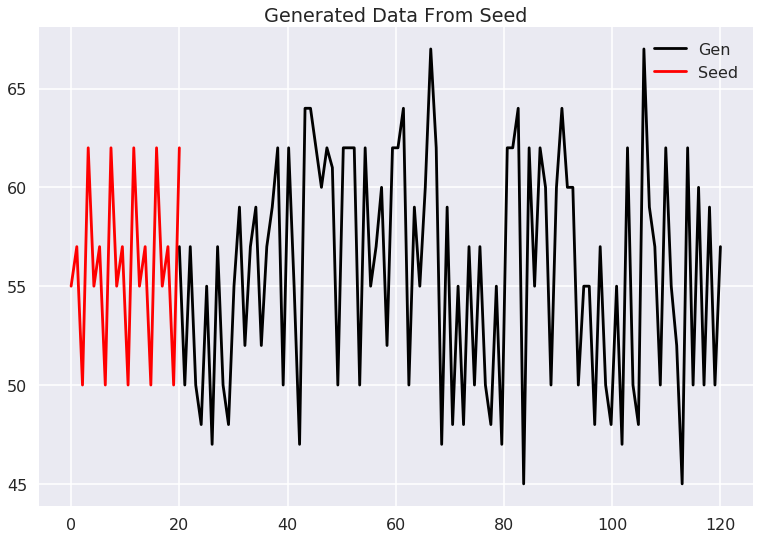

In [7]:
lowx = 0
highx = 100
data = data_seed
plt.plot(np.linspace(0,len(pl_results[lowx:highx]),len(pl_results[lowx:highx]))+sl,pl_results[lowx:highx],'k',label="Gen")
plt.plot(np.linspace(0,len(data[0:sl]),len(data[0:sl])),data[0:sl],'r',label="Seed");
plt.title("Generated Data From Seed")
plt.legend()

In [14]:
notes = mf.convert_to_midi_format(results)
mf.makeMidiOut(notes)

Converting to MIDI


In [16]:
mf.convertMidiToMp3()

Created  mp3Out/Bach_Cantate_BWV20_NNCompose.mp3
